<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Flemming/AML_IceCores_best_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5515.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5516.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5517.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5518.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5519.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_552.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5520.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5521.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5522.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5523.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5524.png  
  inflating: Ins

In [18]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [19]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state = 37)
train = training_set(train_df, sup_im_path)
test = training_set(test_df, sup_im_path)

In [20]:
# save image_size
im_e, lab, feat = sup.__getitem__(147950)
image_size = im_e.shape[0]
image_size

128

In [21]:
train_size = len(train.labels)
test_size = len(test.labels)
print(train_size, test_size)

118368 29592


In [22]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                3936320   
                                                                 
 input_4 (InputLayer)        multiple                  0         
                                                                 
 dense_3 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

# create encoder training
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
for i in range(nr_ims):
    im, lab, feat = train.__getitem__(i)
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 13s 39ms/step - loss: 0.0355 - val_loss: 0.0126
Epoch 2/200
282/282 [==============================] - 10s 36ms/step - loss: 0.0099 - val_loss: 0.0075
Epoch 3/200
282/282 [==============================] - 9s 33ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 4/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 5/200
282/282 [==============================] - 10s 35ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 6/200
282/282 [==============================] - 10s 36ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 7/200
282/282 [==============================] - 10s 36ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 8/200
282/282 [==============================] - 9s 33ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 9/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/200
282/282 [==============================] - 9s 32ms/step - loss: 

In [24]:
encoder.save('encoder')

INFO:tensorflow:Assets written to: encoder/assets


In [25]:
#y_preds = encoder.predict(x_train)
encoder_preds_train = encoder.predict(x_train)

In [26]:
map = umap.UMAP(n_components=2)
#y = map.fit_transform(y_preds)
y = map.fit_transform(encoder_preds_train)

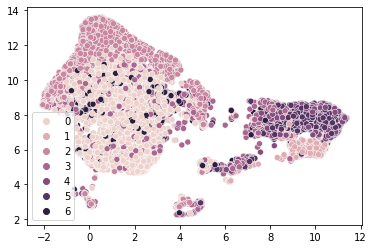

In [27]:
plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab)
plt.show()

In [28]:
!pip install scikit-optimize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


BEST TREE INCOMING

In [29]:
lgb_model = lgb.LGBMClassifier(objective='multiclass')

Depth = [1,3,5,7,10,15,20,25,30,35,40,45,50,100]
Learn_rate = [0.01, 0.05, 0.10, 0.2, 2.5, 0.3, 0.4, 0.5, 1]
Estimators = [10,40,70,100,150,200,250,275,300,325,350,400,500]


parameters_Bayesian = {'max_depth'    :Depth,
                       'learning_rate':Learn_rate,
                       'n_estimators' :Estimators
                        }

BayesSearch = BayesSearchCV(lgb_model, 
                          parameters_Bayesian, 
                          cv=5, 
                          return_train_score=True, 
                          refit=True, 
                          n_iter=7
                         );




for i in range(1):
  # create encoder training
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 15000 # 10-15k images are the max we can load with the memory we have
  for i in range(nr_ims):
      im, lab, feat = train.__getitem__(i)
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  BayesSearch.fit(x_train_with_encoded, x_train_lab)


BayesSearch_results = pd.DataFrame(BayesSearch.cv_results_);
print("BayesSearch_results: \tBest parameters: ", BayesSearch.best_params_, f", Best scores: {BayesSearch.best_score_:.4f}\n")

BayesSearch_results: 	Best parameters:  OrderedDict([('learning_rate', 0.05), ('max_depth', 15), ('n_estimators', 500)]) , Best scores: 0.8625



In [30]:
best_learn, best_depth, best_esti = BayesSearch.best_params_['learning_rate'], BayesSearch.best_params_['max_depth'], BayesSearch.best_params_['n_estimators']

best_learn, best_depth, best_esti = 0.3, 15, 250

In [31]:
tree = lgb.LGBMClassifier(objective='multiclass',
                         learning_rate = best_learn,
                          max_depth = best_depth,
                          n_estimators = best_esti)



for i in range(10):
  # create encoder training
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  for i in range(nr_ims):
      im, lab, feat = train.__getitem__(i)
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  tree.fit(x_train_with_encoded, x_train_lab)


# load the model
#model = pickle.load(open("tree_model_trained.pkl.pkl", "rb"))

NameError: ignored

In [32]:

import pickle
pickle.dump(tree, open("tree_model_trained.pkl", "wb"))

# create testing
tree_encoder_preds_test_preds = ([])
x_test_labs = ([])
for i in range(5):
  x_test = []
  x_test_lab = []
  x_test_feats = []
  nr_ims = 5000
  for i in range(nr_ims):
      im, lab, feat = test.__getitem__(i)
      x_test.append(im)
      x_test_lab.append(lab)
      x_test_labs.append(lab)
      x_test_feats.append(feat)
  x_test = np.array(x_test)
  x_test_lab = np.array(x_test_lab)
  x_test_feats = np.array(x_test_feats)

  encoder_preds_test = encoder.predict(x_test)
  #tree_encoder_preds_test = tree.predict(encoder_preds_test)
  scalar_encoder_combined_test = []
  for i in range(len(x_test_feats)):
      comb = np.append(x_test_feats[i], encoder_preds_test[i])
      scalar_encoder_combined_test.append(comb)
  scalar_encoder_combined_test = np.array(scalar_encoder_combined_test)

  tree_encoder_preds_test = tree.predict(scalar_encoder_combined_test)
  tree_encoder_preds_test_preds.append(tree_encoder_preds_test)

x_test_labs = np.array(x_test_labs)
x_test_labs.resize((1, 25000))
x_test_labs = x_test_labs[0]

tree_encoder_preds_test_preds = np.array(tree_encoder_preds_test_preds)
tree_encoder_preds_test_preds.resize((1, 25000))
tree_encoder_preds_test_preds = list(tree_encoder_preds_test_preds[0])

acc_encoder = sum(tree_encoder_preds_test_preds==x_test_labs)/len(x_test_labs)
acc_encoder

0.8658